# Pipeline Completo: Forecast Promtur - Tráfico Orgánico

**Proyecto:** Predicción de métricas de tráfico orgánico 2026
**Última actualización:** Noviembre 2025

---

## Contenido:

1. **Configuración del entorno** (Local/Colab)
2. **Análisis exploratorio** de datos históricos
3. **Preparación y limpieza** de datos
4. **Modelos de forecasting** con Prophet
5. **Visualización y reportes** finales
6. **Descarga de resultados**

---

## Instrucciones:

### En Google Colab:
1. Ejecuta todas las celdas (Runtime → Run all)
2. Sube tu CSV de GA4 cuando se te pida
3. Los resultados se descargarán automáticamente al final

### En entorno local:
1. Asegúrate de tener el CSV en `data/raw/ga4_promtur_organic_2025.csv`
2. Ejecuta todas las celdas secuencialmente
3. Los resultados se guardarán en las carpetas correspondientes

---

## Archivo CSV requerido:

**Nombre esperado:** `ga4_promtur_organic_2025.csv`

**Columnas requeridas:**
- `Year`
- `Month`
- `Sessions`
- `Bounces`
- `Total session duration`
- `Views`

**Columna opcional:**
- `Channel` - Si no existe, el análisis se realizará para el total agregado

---
# SECCIÓN 0: CONFIGURACIÓN DEL ENTORNO
---

In [105]:
# ===================================================================
# DETECCIÓN AUTOMÁTICA DE ENTORNO (Local vs Colab)
# ===================================================================

import sys
from pathlib import Path

# Detectar si estamos en Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🔵 EJECUTANDO EN GOOGLE COLAB")
    print("=" * 70)
    
    # 1. Instalar dependencias
    print("\n📦 Instalando librerías necesarias...")
    !pip install -q prophet openpyxl
    print("✅ Librerías instaladas")
    
    # 2. Crear estructura de carpetas
    print("\n📁 Creando estructura de carpetas...")
    !mkdir -p data/raw data/processed data/forecasts
    !mkdir -p results/figures/exploratory results/figures/forecasts results/figures/final
    !mkdir -p results/reports
    print("✅ Carpetas creadas")
    
    # 3. Upload de archivo CSV
    from google.colab import files
    import shutil
    
    print("\n" + "=" * 70)
    print("📊 SUBIR ARCHIVO DE DATOS")
    print("=" * 70)
    print("\nPor favor, sube tu archivo CSV de GA4 con los siguientes datos:")
    print("  Requeridas:")
    print("    - Year")
    print("    - Month")
    print("    - Sessions")
    print("    - Bounces")
    print("    - Total session duration")
    print("    - Views")
    print("  Opcional:")
    print("    - Channel (si no existe, se analizará el total agregado)")
    print("\n👇 Haz clic en 'Choose Files' para subir tu CSV:\n")
    
    uploaded = files.upload()
    
    # Mover CSV a data/raw/
    for filename in uploaded.keys():
        # Renombrar al nombre esperado
        shutil.move(filename, 'data/raw/ga4_promtur_organic_2025.csv')
        print(f"\n✅ Archivo guardado como: data/raw/ga4_promtur_organic_2025.csv")
    
    # Definir rutas para Colab
    DATA_RAW = Path('data/raw')
    DATA_PROCESSED = Path('data/processed')
    DATA_FORECASTS = Path('data/forecasts')
    RESULTS_FIGURES_EXPLORATORY = Path('results/figures/exploratory')
    RESULTS_FIGURES_FORECASTS = Path('results/figures/forecasts')
    RESULTS_FIGURES_FINAL = Path('results/figures/final')
    RESULTS_REPORTS = Path('results/reports')
    
    print("\n" + "=" * 70)
    print("✅ CONFIGURACIÓN DE COLAB COMPLETADA")
    print("=" * 70)
    print("\n🚀 Procede a ejecutar el resto del notebook\n")
    
else:
    print("🟢 EJECUTANDO EN ENTORNO LOCAL")
    print("=" * 70)
    
    # Definir rutas para entorno local
    DATA_RAW = Path('../data/raw')
    DATA_PROCESSED = Path('../data/processed')
    DATA_FORECASTS = Path('../data/forecasts')
    RESULTS_FIGURES_EXPLORATORY = Path('../results/figures/exploratory')
    RESULTS_FIGURES_FORECASTS = Path('../results/figures/forecasts')
    RESULTS_FIGURES_FINAL = Path('../results/figures/final')
    RESULTS_REPORTS = Path('../results/reports')
    
    # Crear carpetas si no existen
    for folder in [DATA_RAW, DATA_PROCESSED, DATA_FORECASTS, 
                   RESULTS_FIGURES_EXPLORATORY, RESULTS_FIGURES_FORECASTS, 
                   RESULTS_FIGURES_FINAL, RESULTS_REPORTS]:
        folder.mkdir(parents=True, exist_ok=True)
    
    print("✅ Entorno local configurado")
    print("\n🚀 Procede a ejecutar el resto del notebook\n")

🟢 EJECUTANDO EN ENTORNO LOCAL
✅ Entorno local configurado

🚀 Procede a ejecutar el resto del notebook



In [106]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from datetime import timedelta
import warnings

# Ignorar warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Semilla para reproducibilidad
np.random.seed(42)

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


In [107]:
# Función auxiliar para formatear duración
def segundos_a_hhmm_ss(segundos):
    """
    Convierte segundos a formato HH:MM:SS
    """
    if pd.isna(segundos) or segundos < 0:
        return "00:00:00"
    
    horas = int(segundos // 3600)
    minutos = int((segundos % 3600) // 60)
    segs = int(segundos % 60)
    
    return f"{horas:02d}:{minutos:02d}:{segs:02d}"

print("✅ Funciones auxiliares creadas")

✅ Funciones auxiliares creadas


---
# SECCIÓN 1: ANÁLISIS EXPLORATORIO
---

## 1.1 Carga y exploración inicial de datos

In [108]:
# Cargar dataset
csv_file = DATA_RAW / 'ga4_promtur_organic_2025.csv'

if csv_file.exists():
    df_raw = pd.read_csv(csv_file)
    print(f"✅ Dataset cargado exitosamente")
    print(f"📊 Dimensiones: {df_raw.shape[0]} filas x {df_raw.shape[1]} columnas\n")
else:
    print(f"❌ Error: No se encontró el archivo {csv_file}")

✅ Dataset cargado exitosamente
📊 Dimensiones: 82 filas x 7 columnas



In [109]:
# Configuración de nombres de columnas originales
year_col = 'Year'
month_col = 'Month'
canal_col = 'Channel'
sessions_col = 'Sessions'
bounces_col = 'Bounces'
duration_col = 'Total session duration'
views_col = 'Views'

print("✅ Variables de columnas configuradas")

✅ Variables de columnas configuradas


In [110]:
# Detección automática de columna de canal
print("\n" + "=" * 70)
print("DETECCION DE ESTRUCTURA DEL DATASET")
print("=" * 70)

if canal_col not in df_raw.columns:
    print(f"\n⚠️ No se detectó la columna '{canal_col}'.")
    print("Creando columna de canal con valor 'Total'...")
    df_raw[canal_col] = 'Total'
    print("\n📊 El análisis se realizará para el total agregado (sin separación por canales).")
    print("Resultado: 1 conjunto de modelos, 4 gráficos, 1 tabla.")
else:
    canales_detectados = df_raw[canal_col].nunique()
    print(f"\n✅ Columna '{canal_col}' detectada correctamente.")
    print(f"📊 Canales encontrados: {canales_detectados}")
    print(f"Resultado: {canales_detectados} conjuntos de modelos, {canales_detectados * 4} gráficos, {canales_detectados} tablas.")

print("\n" + "=" * 70)


DETECCION DE ESTRUCTURA DEL DATASET

✅ Columna 'Channel' detectada correctamente.
📊 Canales encontrados: 9
Resultado: 9 conjuntos de modelos, 36 gráficos, 9 tablas.



In [111]:
# Primeras filas
print("📋 Primeras 10 filas del dataset:\n")
display(df_raw.head(10))

📋 Primeras 10 filas del dataset:



,Year,Month,Channel,Sessions,Bounces,Total session duration,Views
0,2025,1,Organic Video,47,2,14312.62,136
1,2025,1,Organic Search,100704,7431,22668945.35,190855
2,2025,1,Organic Social,854,84,99585.90,1405
3,2025,1,AI Traffic,503,76,119434.35,713
4,2025,1,Direct,48760,1406,7407673.63,96176
5,2025,1,Referral,5951,960,1508823.55,13732
6,2025,2,Email,2,1,984.62,14
7,2025,2,Organic Social,706,16,161798.32,1708
8,2025,2,AI Traffic,480,36,112315.79,866
9,2025,2,Direct,12843,303,3044052.22,22413


In [112]:
# Información del dataset
print("ℹ️ Información del dataset:\n")
df_raw.info()

ℹ️ Información del dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Year                    82 non-null     int64  
 1   Month                   82 non-null     int64  
 2   Channel                 82 non-null     object 
 3   Sessions                82 non-null     int64  
 4   Bounces                 82 non-null     int64  
 5   Total session duration  82 non-null     float64
 6   Views                   82 non-null     int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 4.6+ KB


In [113]:
# Verificar canales y rango temporal
print("🎯 Canales únicos encontrados:\n")
print(df_raw[canal_col].value_counts().sort_index())

print(f"\n📅 Rango temporal:")
print(f"   Año(s): {sorted(df_raw[year_col].unique())}")
print(f"   Meses: {sorted(df_raw[month_col].unique())}")
print(f"   Total de meses únicos: {df_raw[[year_col, month_col]].drop_duplicates().shape[0]}")

🎯 Canales únicos encontrados:

Channel
AI Traffic          11
Direct              11
Email               10
Organic Search      11
Organic Shopping     4
Organic Social      11
Organic Video       11
QR Code              2
Referral            11
Name: count, dtype: int64

📅 Rango temporal:
   Año(s): [np.int64(2025)]
   Meses: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)]
   Total de meses únicos: 11


## 1.2 Calidad de datos

In [114]:
# Verificar valores faltantes
missing = df_raw.isnull().sum()
if missing.sum() > 0:
    print("⚠️ Valores faltantes encontrados:\n")
    display(missing[missing > 0])
else:
    print("✅ No hay valores faltantes")

# Verificar duplicados
duplicados = df_raw.duplicated().sum()
print(f"\n🔍 Registros duplicados: {duplicados}")
if duplicados == 0:
    print("✅ No hay registros duplicados")

✅ No hay valores faltantes

🔍 Registros duplicados: 0
✅ No hay registros duplicados


## 1.3 Visualizaciones exploratorias

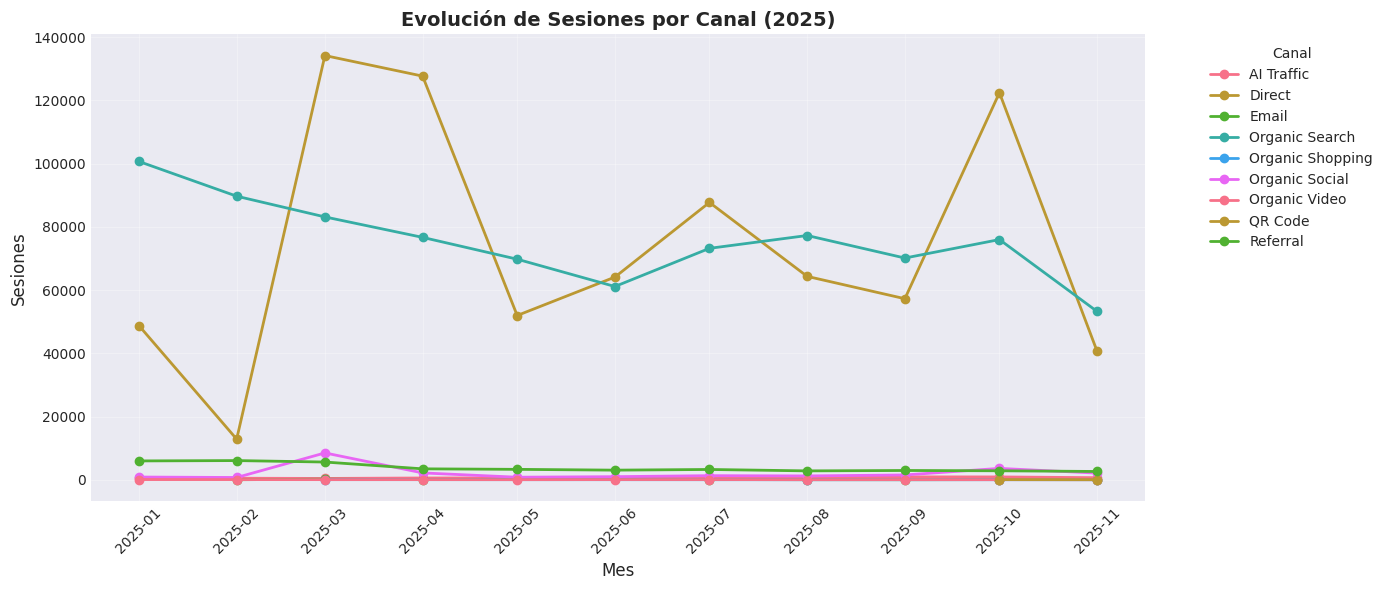

💾 Gráfico guardado


In [115]:
# Crear columna de fecha
df_raw['fecha'] = pd.to_datetime(
    df_raw[year_col].astype(str) + '-' + df_raw[month_col].astype(str) + '-01'
)

# Gráfico: Evolución de sesiones por canal
fig, ax = plt.subplots(figsize=(14, 6))

for canal in sorted(df_raw[canal_col].unique()):
    data_canal = df_raw[df_raw[canal_col] == canal].sort_values('fecha')
    ax.plot(data_canal['fecha'], data_canal[sessions_col], 
            marker='o', label=canal, linewidth=2, markersize=6)

ax.set_xlabel('Mes', fontsize=12)
ax.set_ylabel('Sesiones', fontsize=12)
ax.set_title('Evolución de Sesiones por Canal (2025)', fontsize=14, fontweight='bold')
ax.legend(title='Canal', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(RESULTS_FIGURES_EXPLORATORY / 'sessions_by_channel.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Gráfico guardado")

---
# SECCIÓN 2: PREPARACIÓN Y LIMPIEZA DE DATOS
---

## 2.1 Transformación a snake_case

In [116]:
# Mapeo de columnas a snake_case
column_mapping = {
    'Year': 'year',
    'Month': 'month',
    'Channel': 'channel',
    'Sessions': 'sessions',
    'Bounces': 'bounces',
    'Total session duration': 'total_session_duration',
    'Views': 'views'
}

df_clean = df_raw.rename(columns=column_mapping)

print("✅ Columnas renombradas a snake_case")
print(f"\nColumnas del dataset limpio: {list(df_clean.columns)}")

✅ Columnas renombradas a snake_case

Columnas del dataset limpio: ['year', 'month', 'channel', 'sessions', 'bounces', 'total_session_duration', 'views', 'fecha']


## 2.2 Cálculo de métricas derivadas

In [117]:
# Calcular métricas derivadas
df_clean['bounce_rate'] = (df_clean['bounces'] / df_clean['sessions']) * 100
df_clean['views_per_session'] = df_clean['views'] / df_clean['sessions']
df_clean['avg_session_duration'] = df_clean['total_session_duration'] / df_clean['sessions']

# Crear columna de fecha
df_clean['ds'] = pd.to_datetime(
    df_clean['year'].astype(str) + '-' + df_clean['month'].astype(str) + '-01'
)

print("✅ Métricas derivadas calculadas:")
print("   - bounce_rate (%)")
print("   - views_per_session")
print("   - avg_session_duration (segundos)")

# Mostrar muestra
print("\n📊 Muestra de datos procesados:\n")
display(df_clean[['year', 'month', 'channel', 'sessions', 'bounce_rate', 
                   'views_per_session', 'avg_session_duration']].head(10))

✅ Métricas derivadas calculadas:
   - bounce_rate (%)
   - views_per_session
   - avg_session_duration (segundos)

📊 Muestra de datos procesados:



,year,month,channel,sessions,bounce_rate,views_per_session,avg_session_duration
0,2025,1,Organic Video,47,4.26,2.89,304.52
1,2025,1,Organic Search,100704,7.38,1.90,225.10
2,2025,1,Organic Social,854,9.84,1.65,116.61
3,2025,1,AI Traffic,503,15.11,1.42,237.44
4,2025,1,Direct,48760,2.88,1.97,151.92
5,2025,1,Referral,5951,16.13,2.31,253.54
6,2025,2,Email,2,50.00,7.00,492.31
7,2025,2,Organic Social,706,2.27,2.42,229.18
8,2025,2,AI Traffic,480,7.50,1.80,233.99
9,2025,2,Direct,12843,2.36,1.75,237.02


## 2.3 Filtrado de canales (OPCIONAL)

In [118]:
# Configuración: usar todos los canales o filtrar
usar_todos_los_canales = False

if usar_todos_los_canales:
    df_final = df_clean.copy()
    print(f"✅ Usando TODOS los canales ({df_final['channel'].nunique()} canales)")
    print(f"\nCanales incluidos:")
    for canal in sorted(df_final['channel'].unique()):
        print(f"   - {canal}")
else:
    # Puedes personalizar esta lista
    canales_incluir = [    
    'Organic Search',
    'Direct',
    #'Referral',
    'Organic Social',
    'AI Traffic',
    'Email'
    'Organic Video'
    #'QR Code',
    #'Organic Shopping'
    # Agrega o quita canales según necesites
    ]
    
    # Si existe canal 'Total', siempre incluirlo
    if 'Total' in df_clean['channel'].unique():
        print("⚠️ Detectado canal 'Total' (dataset sin separación por canales).")
        print("El filtrado se omitirá y se usará el total agregado.")
        df_final = df_clean.copy()
    else:
        df_final = df_clean[df_clean['channel'].isin(canales_incluir)].copy()
        print(f"✅ Filtrado aplicado: {len(canales_incluir)} canales seleccionados")

✅ Filtrado aplicado: 5 canales seleccionados


## 2.4 Guardado de dataset limpio

In [119]:
# Seleccionar columnas finales
columnas_finales = [
    'year', 'month', 'channel', 'sessions', 'bounces', 
    'total_session_duration', 'views', 'bounce_rate', 
    'views_per_session', 'avg_session_duration', 'ds'
]

df_output = df_final[columnas_finales].copy()
df_output = df_output.sort_values(['year', 'month', 'channel']).reset_index(drop=True)

# Guardar
output_file = DATA_PROCESSED / 'dataset_clean.csv'
df_output.to_csv(output_file, index=False)

print(f"✅ Dataset limpio guardado en: {output_file}")
print(f"📊 Dimensiones: {df_output.shape[0]} filas x {df_output.shape[1]} columnas")

✅ Dataset limpio guardado en: ../data/processed/dataset_clean.csv
📊 Dimensiones: 44 filas x 11 columnas


---
# SECCIÓN 3: MODELOS DE FORECASTING
---

## 3.1 Configuración de forecasting

In [120]:
# Configuración
metricas_forecast = ['sessions', 'bounce_rate', 'views_per_session', 'avg_session_duration']
canales = sorted(df_output['channel'].unique())
periodos_forecast = 12  # 12 meses de 2026

print(f"📊 Configuración de forecasting:")
print(f"\n   Métricas: {len(metricas_forecast)}")
for m in metricas_forecast:
    print(f"      - {m}")
print(f"\n   Canales: {len(canales)}")
for c in canales:
    print(f"      - {c}")
print(f"\n   Horizonte: {periodos_forecast} meses (2026)")
print(f"\n   Total de modelos: {len(metricas_forecast)} × {len(canales)} = {len(metricas_forecast) * len(canales)}")

📊 Configuración de forecasting:

   Métricas: 4
      - sessions
      - bounce_rate
      - views_per_session
      - avg_session_duration

   Canales: 4
      - AI Traffic
      - Direct
      - Organic Search
      - Organic Social

   Horizonte: 12 meses (2026)

   Total de modelos: 4 × 4 = 16


## 3.2 Función de forecasting

In [121]:
def crear_forecast_prophet(df_canal, metrica, periodos=12):
    """
    Crea forecast con Prophet
    """
    # Preparar datos
    df_prophet = df_canal[['ds', metrica]].rename(columns={metrica: 'y'})
    
    # Modelo
    model = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        interval_width=0.95
    )
    
    model.fit(df_prophet)
    
    # Predicciones
    future = model.make_future_dataframe(periods=periodos, freq='MS')
    forecast = model.predict(future)
    
    # Métricas de evaluación
    forecast_hist = forecast[forecast['ds'].isin(df_prophet['ds'])]
    valores_reales = df_prophet['y'].values
    valores_pred = forecast_hist['yhat'].values
    
    mae = np.mean(np.abs(valores_reales - valores_pred))
    rmse = np.sqrt(np.mean((valores_reales - valores_pred)**2))
    mape = np.mean(np.abs((valores_reales - valores_pred) / valores_reales)) * 100
    
    return model, forecast, {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

print("✅ Función de forecasting creada")

✅ Función de forecasting creada


## 3.3 Entrenamiento de modelos

In [122]:
# Entrenar modelos
resultados_forecasts = {}
metricas_evaluacion = {}

print("🚀 Entrenando modelos...\n")
print("="*70)

total = len(canales) * len(metricas_forecast)
actual = 0

for canal in canales:
    print(f"\n📊 Canal: {canal}")
    print("-" * 70)
    
    df_canal = df_output[df_output['channel'] == canal].sort_values('ds')
    resultados_forecasts[canal] = {}
    metricas_evaluacion[canal] = {}
    
    for metrica in metricas_forecast:
        actual += 1
        print(f"   [{actual}/{total}] {metrica}...", end=" ")
        
        model, forecast, metrics = crear_forecast_prophet(df_canal, metrica, periodos_forecast)
        
        resultados_forecasts[canal][metrica] = forecast
        metricas_evaluacion[canal][metrica] = metrics
        
        print(f"MAPE: {metrics['MAPE']:.2f}%")

print("\n" + "="*70)
print("✅ Todos los modelos entrenados")

20:38:12 - cmdstanpy - INFO - Chain [1] start processing
20:38:12 - cmdstanpy - INFO - Chain [1] done processing


🚀 Entrenando modelos...


📊 Canal: AI Traffic
----------------------------------------------------------------------
   [1/16] sessions... MAPE: 10.25%
   [2/16] bounce_rate... 

20:38:12 - cmdstanpy - INFO - Chain [1] start processing
20:38:12 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 32.37%
   [3/16] views_per_session... 

20:38:12 - cmdstanpy - INFO - Chain [1] start processing
20:38:12 - cmdstanpy - INFO - Chain [1] done processing
20:38:12 - cmdstanpy - INFO - Chain [1] start processing
20:38:12 - cmdstanpy - INFO - Chain [1] done processing
20:38:12 - cmdstanpy - INFO - Chain [1] start processing
20:38:12 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 5.43%
   [4/16] avg_session_duration... MAPE: 14.14%

📊 Canal: Direct
----------------------------------------------------------------------
   [5/16] sessions... MAPE: 76.11%
   [6/16] bounce_rate... 

20:38:12 - cmdstanpy - INFO - Chain [1] start processing
20:38:12 - cmdstanpy - INFO - Chain [1] done processing
20:38:12 - cmdstanpy - INFO - Chain [1] start processing
20:38:12 - cmdstanpy - INFO - Chain [1] done processing
20:38:12 - cmdstanpy - INFO - Chain [1] start processing
20:38:12 - cmdstanpy - INFO - Chain [1] done processing
20:38:12 - cmdstanpy - INFO - Chain [1] start processing
20:38:12 - cmdstanpy - INFO - Chain [1] done processing
20:38:12 - cmdstanpy - INFO - Chain [1] start processing


MAPE: 245.30%
   [7/16] views_per_session... MAPE: 13.41%
   [8/16] avg_session_duration... MAPE: 27.84%

📊 Canal: Organic Search
----------------------------------------------------------------------
   [9/16] sessions... MAPE: 9.37%
   [10/16] bounce_rate... 

20:38:13 - cmdstanpy - INFO - Chain [1] done processing
20:38:13 - cmdstanpy - INFO - Chain [1] start processing
20:38:13 - cmdstanpy - INFO - Chain [1] done processing
20:38:13 - cmdstanpy - INFO - Chain [1] start processing
20:38:13 - cmdstanpy - INFO - Chain [1] done processing
20:38:13 - cmdstanpy - INFO - Chain [1] start processing
20:38:13 - cmdstanpy - INFO - Chain [1] done processing
20:38:13 - cmdstanpy - INFO - Chain [1] start processing


MAPE: 41.95%
   [11/16] views_per_session... MAPE: 1.96%
   [12/16] avg_session_duration... MAPE: 2.22%

📊 Canal: Organic Social
----------------------------------------------------------------------
   [13/16] sessions... MAPE: 91.20%
   [14/16] bounce_rate... 

20:38:13 - cmdstanpy - INFO - Chain [1] done processing
20:38:13 - cmdstanpy - INFO - Chain [1] start processing
20:38:13 - cmdstanpy - INFO - Chain [1] done processing
20:38:13 - cmdstanpy - INFO - Chain [1] start processing
20:38:13 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 172.70%
   [15/16] views_per_session... MAPE: 12.53%
   [16/16] avg_session_duration... MAPE: 45.07%

✅ Todos los modelos entrenados


## 3.4 Exportación de predicciones

In [123]:
# Consolidar predicciones 2026
predicciones_2026 = []

for canal in canales:
    for metrica in metricas_forecast:
        forecast = resultados_forecasts[canal][metrica]
        forecast_2026 = forecast[forecast['ds'].dt.year == 2026][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
        
        forecast_2026['channel'] = canal
        forecast_2026['metric'] = metrica
        forecast_2026['year'] = 2026
        forecast_2026['month'] = forecast_2026['ds'].dt.month
        
        forecast_2026 = forecast_2026.rename(columns={
            'yhat': 'predicted_value',
            'yhat_lower': 'lower_bound',
            'yhat_upper': 'upper_bound'
        })
        
        predicciones_2026.append(forecast_2026)

df_predicciones = pd.concat(predicciones_2026, ignore_index=True)
df_predicciones = df_predicciones[[
    'year', 'month', 'channel', 'metric', 
    'predicted_value', 'lower_bound', 'upper_bound', 'ds'
]].sort_values(['channel', 'metric', 'year', 'month']).reset_index(drop=True)

# Guardar
forecast_file = DATA_FORECASTS / 'forecasts_2026_all_channels.csv'
df_predicciones.to_csv(forecast_file, index=False)

print(f"✅ Predicciones guardadas en: {forecast_file}")
print(f"📊 Total de predicciones: {len(df_predicciones)}")

✅ Predicciones guardadas en: ../data/forecasts/forecasts_2026_all_channels.csv
📊 Total de predicciones: 176


---
# SECCIÓN 4: VISUALIZACIÓN Y REPORTES
---

## 4.1 Ajuste de bounce_rate (0-100%)

In [124]:
# Limitar bounce_rate a 0-100%
mask_bounce = df_predicciones['metric'] == 'bounce_rate'

print("🔧 Aplicando limitación de bounce_rate a 0-100%...")

df_predicciones.loc[mask_bounce, 'predicted_value'] = df_predicciones.loc[mask_bounce, 'predicted_value'].clip(0, 100)
df_predicciones.loc[mask_bounce, 'lower_bound'] = df_predicciones.loc[mask_bounce, 'lower_bound'].clip(0, 100)
df_predicciones.loc[mask_bounce, 'upper_bound'] = df_predicciones.loc[mask_bounce, 'upper_bound'].clip(0, 100)

print("✅ Bounce_rate limitado correctamente")

🔧 Aplicando limitación de bounce_rate a 0-100%...
✅ Bounce_rate limitado correctamente


## 4.2 Análisis de confiabilidad

In [125]:
# Identificar canales poco confiables
canales_confiabilidad = []

for canal in canales:
    df_canal_pred = df_predicciones[df_predicciones['channel'] == canal]
    df_canal_hist = df_output[df_output['channel'] == canal]
    
    volumen = df_canal_hist['sessions'].mean()
    
    metricas_positivas = ['sessions', 'views_per_session', 'avg_session_duration']
    negativos = df_canal_pred[
        df_canal_pred['metric'].isin(metricas_positivas) & 
        (df_canal_pred['predicted_value'] < 0)
    ].shape[0]
    
    problemas = []
    if volumen < 100:
        problemas.append('Bajo volumen')
    if negativos > 0:
        problemas.append('Valores negativos')
    
    confiabilidad = 'BAJA' if problemas else ('MEDIA' if volumen < 1000 else 'ALTA')
    
    canales_confiabilidad.append({
        'canal': canal,
        'volumen_promedio': volumen,
        'confiabilidad': confiabilidad,
        'problemas': ', '.join(problemas) if problemas else 'Ninguno'
    })

df_confiabilidad = pd.DataFrame(canales_confiabilidad).sort_values('volumen_promedio', ascending=False)

print("📊 Análisis de confiabilidad:\n")
display(df_confiabilidad)

# Guardar
df_confiabilidad.to_csv(RESULTS_REPORTS / 'canales_confiabilidad.csv', index=False)
print(f"\n💾 Análisis guardado")

📊 Análisis de confiabilidad:



,canal,volumen_promedio,confiabilidad,problemas
2,Organic Search,75552.36,ALTA,Ninguno
1,Direct,73824.45,ALTA,Ninguno
3,Organic Social,2149.18,ALTA,Ninguno
0,AI Traffic,621.73,MEDIA,Ninguno



💾 Análisis guardado


## 4.3 Tablas resumen por canal

In [126]:
# Crear tablas resumen (métricas × meses) con duración en HH:MM:SS
def crear_tabla_resumen(canal):
    df_canal = df_predicciones[df_predicciones['channel'] == canal].copy()
    df_canal['mes'] = df_canal['ds'].dt.strftime('%b-%y')
    
    tabla = df_canal.pivot(index='metric', columns='mes', values='predicted_value')
    
    meses_orden = df_canal.sort_values('ds')['mes'].unique()
    tabla = tabla[meses_orden]
    tabla['Promedio'] = tabla.mean(axis=1)
    
    # Crear fila adicional con duración en formato HH:MM:SS
    if 'avg_session_duration' in tabla.index:
        duracion_seg = tabla.loc['avg_session_duration'].copy()
        duracion_formateada = duracion_seg.apply(segundos_a_hhmm_ss)
        
        # Agregar fila formateada justo después de la fila en segundos
        tabla.loc['avg_session_duration_formatted'] = duracion_formateada
    
    nombres = {
        'sessions': 'Sesiones',
        'bounce_rate': 'Bounce Rate (%)',
        'views_per_session': 'Vistas/Sesión',
        'avg_session_duration': 'Duración Avg (seg)',
        'avg_session_duration_formatted': 'Duración Avg (HH:MM:SS)'
    }
    tabla = tabla.rename(index=nombres)
    
    return tabla.round(2)

# Generar y mostrar tablas
print("📊 TABLAS RESUMEN POR CANAL\n")
print("="*80)

tablas = {}
for canal in canales:
    print(f"\n📈 {canal}")
    print("-"*80)
    
    conf = df_confiabilidad[df_confiabilidad['canal'] == canal]['confiabilidad'].values[0]
    if conf == 'BAJA':
        print("⚠️ ADVERTENCIA: Confiabilidad BAJA\n")
    
    tabla = crear_tabla_resumen(canal)
    tablas[canal] = tabla
    display(tabla)

print("\n" + "="*80)

📊 TABLAS RESUMEN POR CANAL


📈 AI Traffic
--------------------------------------------------------------------------------


mes,Jan-26,Feb-26,Mar-26,Apr-26,May-26,Jun-26,Jul-26,Aug-26,Sep-26,Oct-26,Nov-26,Promedio
metric,,,,,,,,,,,,
Duración Avg (seg),269.22,272.61,275.68,279.08,282.36,285.76,289.05,292.44,295.84,299.13,302.52,285.79
Bounce Rate (%),31.73,33.19,34.51,35.97,37.39,38.85,40.26,41.73,43.19,44.60,46.06,38.86
Sesiones,885.63,923.96,958.58,996.91,1034.01,1072.34,1109.43,1147.76,1186.09,1223.18,1261.51,1072.67
Vistas/Sesión,1.66,1.67,1.68,1.69,1.70,1.71,1.72,1.73,1.74,1.75,1.77,1.71
Duración Avg (HH:MM:SS),00:04:29,00:04:32,00:04:35,00:04:39,00:04:42,00:04:45,00:04:49,00:04:52,00:04:55,00:04:59,00:05:02,00:04:45



📈 Direct
--------------------------------------------------------------------------------


mes,Jan-26,Feb-26,Mar-26,Apr-26,May-26,Jun-26,Jul-26,Aug-26,Sep-26,Oct-26,Nov-26,Promedio
metric,,,,,,,,,,,,
Duración Avg (seg),87.33,83.17,79.42,75.26,71.23,67.07,63.05,58.89,54.73,50.70,46.54,67.04
Bounce Rate (%),56.95,59.91,62.59,65.56,68.43,71.39,74.26,77.23,80.19,83.06,86.03,71.42
Sesiones,78407.99,79069.30,79666.60,80327.91,80967.88,81629.19,82269.16,82930.46,83591.77,84231.74,84893.04,81635.00
Vistas/Sesión,0.78,0.71,0.65,0.58,0.51,0.44,0.38,0.31,0.24,0.17,0.10,0.44
Duración Avg (HH:MM:SS),00:01:27,00:01:23,00:01:19,00:01:15,00:01:11,00:01:07,00:01:03,00:00:58,00:00:54,00:00:50,00:00:46,00:01:07



📈 Organic Search
--------------------------------------------------------------------------------


mes,Jan-26,Feb-26,Mar-26,Apr-26,May-26,Jun-26,Jul-26,Aug-26,Sep-26,Oct-26,Nov-26,Promedio
metric,,,,,,,,,,,,
Duración Avg (seg),219.59,219.15,218.76,218.33,217.91,217.48,217.06,216.62,216.19,215.77,215.34,217.47
Bounce Rate (%),27.76,29.43,30.93,32.59,34.21,35.87,37.48,39.14,40.81,42.42,44.08,35.88
Sesiones,54795.10,51783.71,49063.74,46052.35,43138.10,40126.71,37212.46,34201.07,31189.68,28275.44,25264.04,40100.22
Vistas/Sesión,1.69,1.68,1.67,1.66,1.64,1.63,1.62,1.61,1.60,1.59,1.57,1.63
Duración Avg (HH:MM:SS),00:03:39,00:03:39,00:03:38,00:03:38,00:03:37,00:03:37,00:03:37,00:03:36,00:03:36,00:03:35,00:03:35,00:03:37



📈 Organic Social
--------------------------------------------------------------------------------


mes,Jan-26,Feb-26,Mar-26,Apr-26,May-26,Jun-26,Jul-26,Aug-26,Sep-26,Oct-26,Nov-26,Promedio
metric,,,,,,,,,,,,
Duración Avg (seg),106.24,105.36,104.57,103.69,102.84,101.96,101.11,100.23,99.35,98.50,97.62,101.95
Bounce Rate (%),51.11,53.76,56.15,58.80,61.36,64.01,66.57,69.22,71.87,74.43,77.08,64.03
Sesiones,1834.76,1789.23,1748.11,1702.58,1658.52,1612.99,1568.93,1523.40,1477.87,1433.81,1388.28,1612.59
Vistas/Sesión,1.12,1.06,1.01,0.95,0.90,0.84,0.79,0.73,0.68,0.62,0.56,0.84
Duración Avg (HH:MM:SS),00:01:46,00:01:45,00:01:44,00:01:43,00:01:42,00:01:41,00:01:41,00:01:40,00:01:39,00:01:38,00:01:37,00:01:41


In [127]:
# Exportar tablas a Excel con formato HH:MM:SS
excel_file = RESULTS_REPORTS / 'tablas_resumen_2026.xlsx'

with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
    for canal, tabla in tablas.items():
        sheet_name = canal[:31]
        tabla.to_excel(writer, sheet_name=sheet_name)

print(f"💾 Tablas exportadas a: {excel_file}")
print(f"\n✅ Nota: Las tablas incluyen duración en segundos Y en formato HH:MM:SS")

💾 Tablas exportadas a: ../results/reports/tablas_resumen_2026.xlsx

✅ Nota: Las tablas incluyen duración en segundos Y en formato HH:MM:SS


## 4.4 Gráficos comparativos (TODAS las métricas)

📊 Generando gráficos comparativos para todas las métricas...


📈 Canal: AI Traffic
----------------------------------------------------------------------
   Gráfico: Sesiones


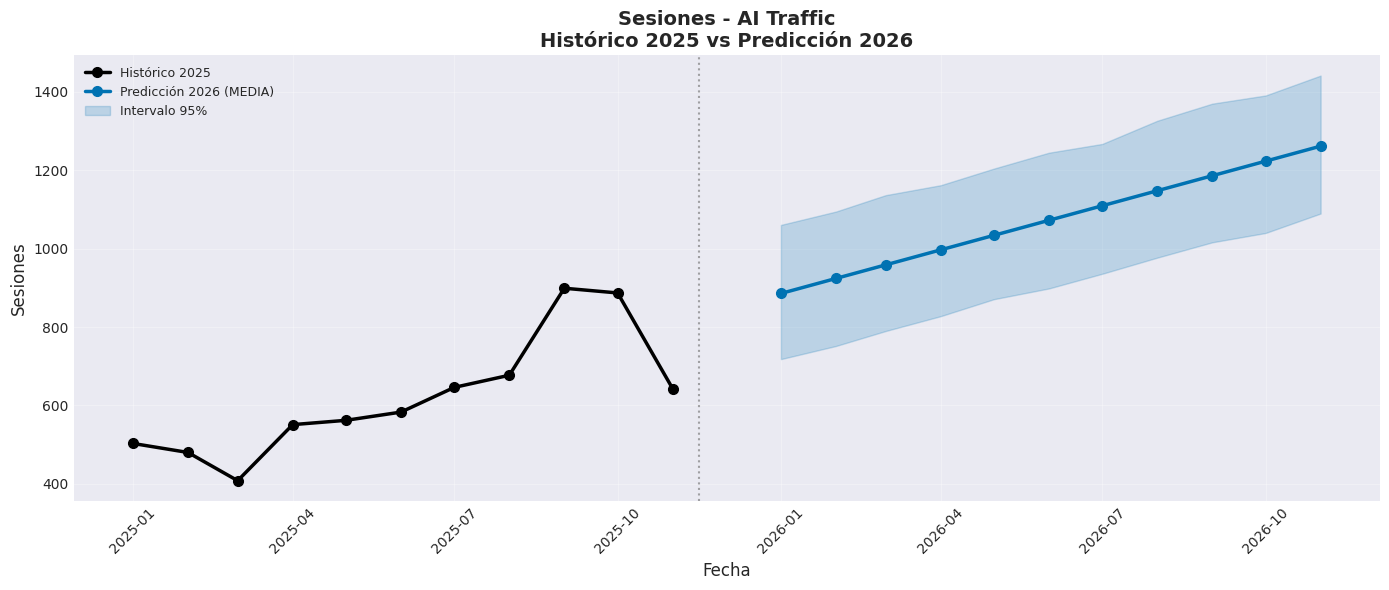

   Gráfico: Bounce Rate (%)


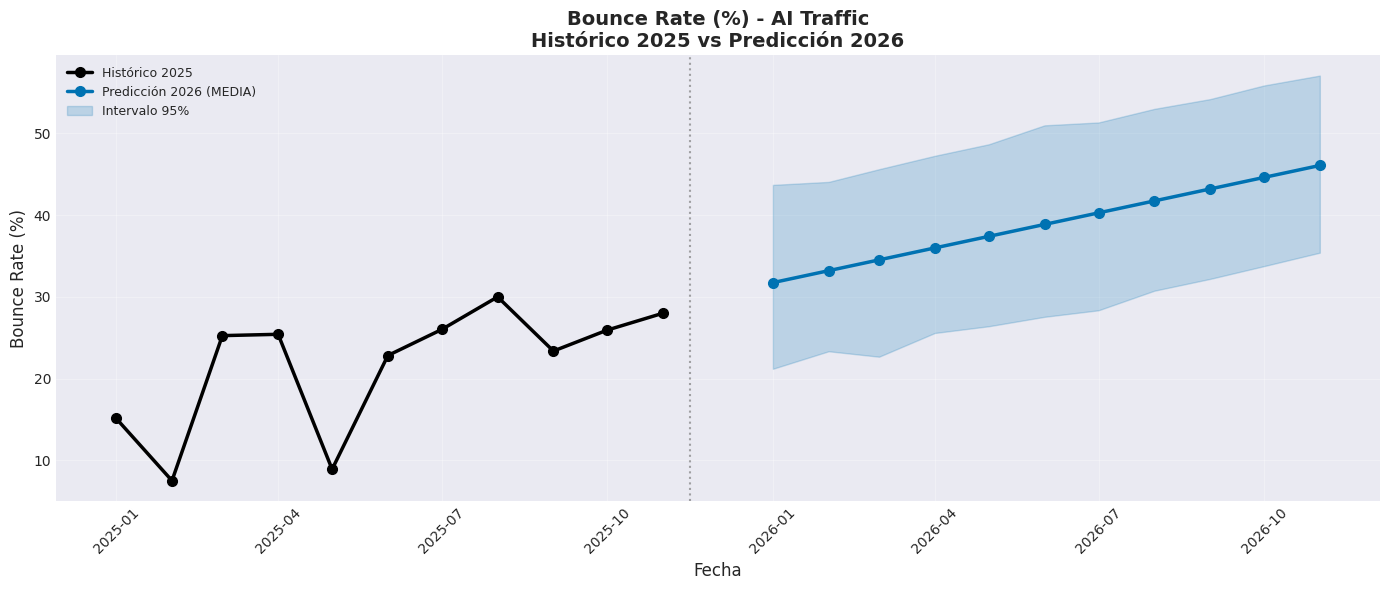

   Gráfico: Vistas por Sesión


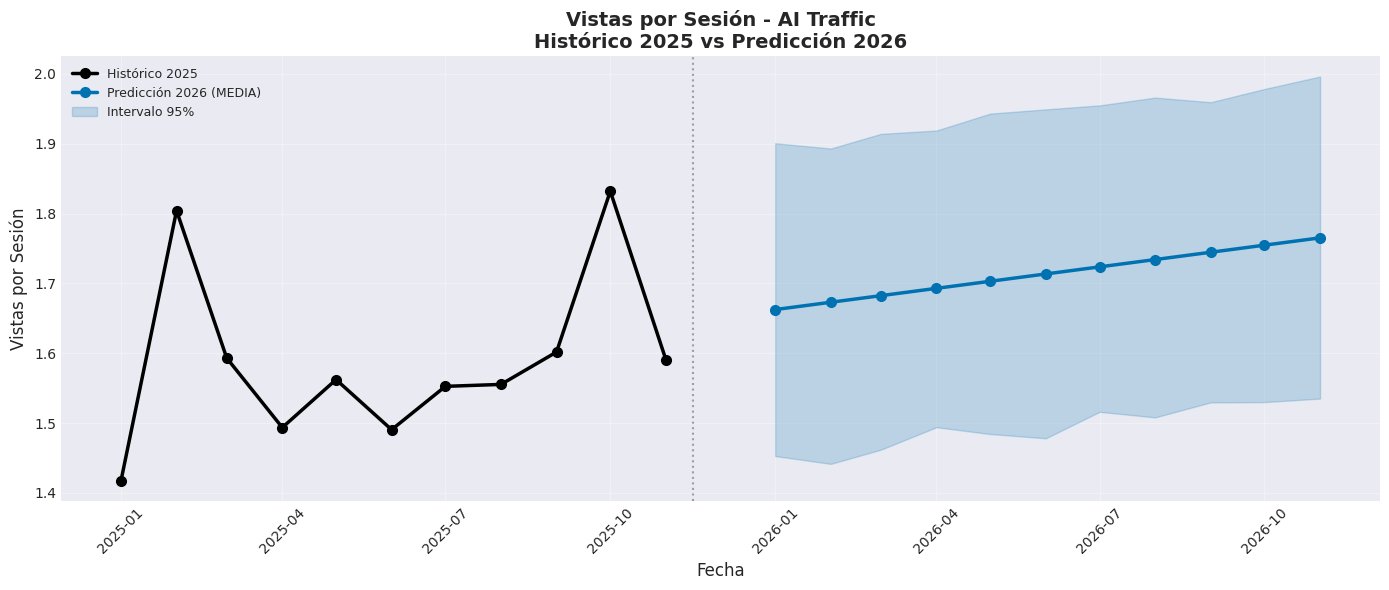

   Gráfico: Duración Promedio (segundos)


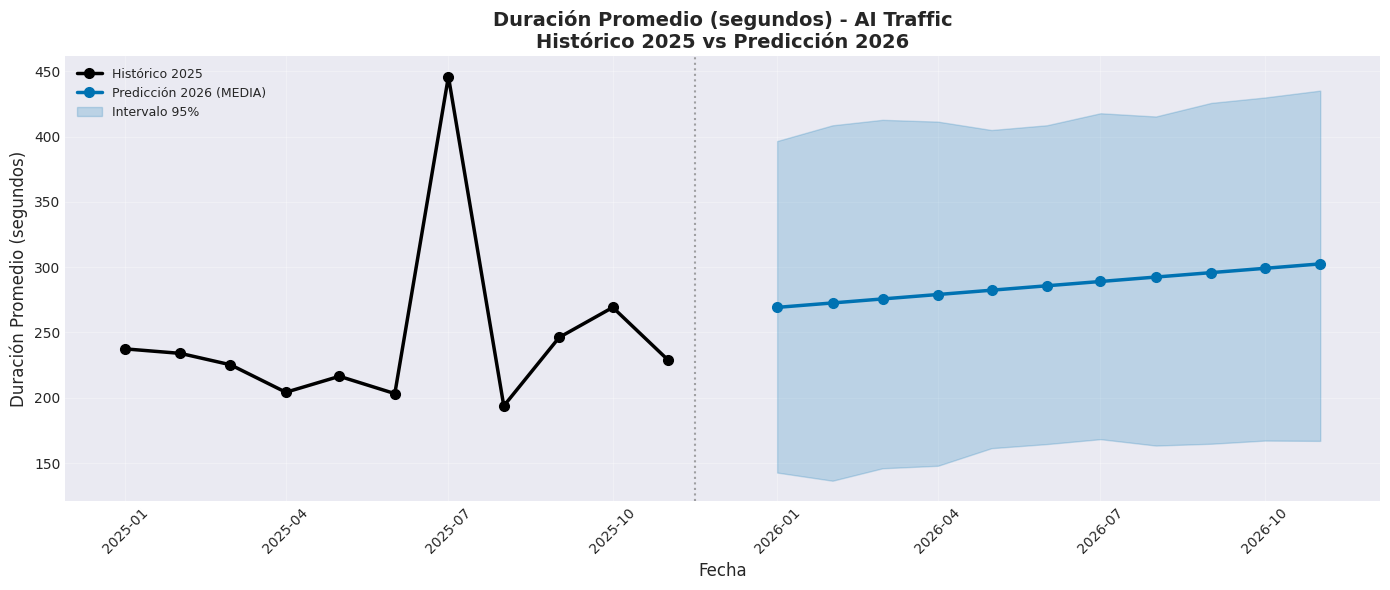


📈 Canal: Direct
----------------------------------------------------------------------
   Gráfico: Sesiones


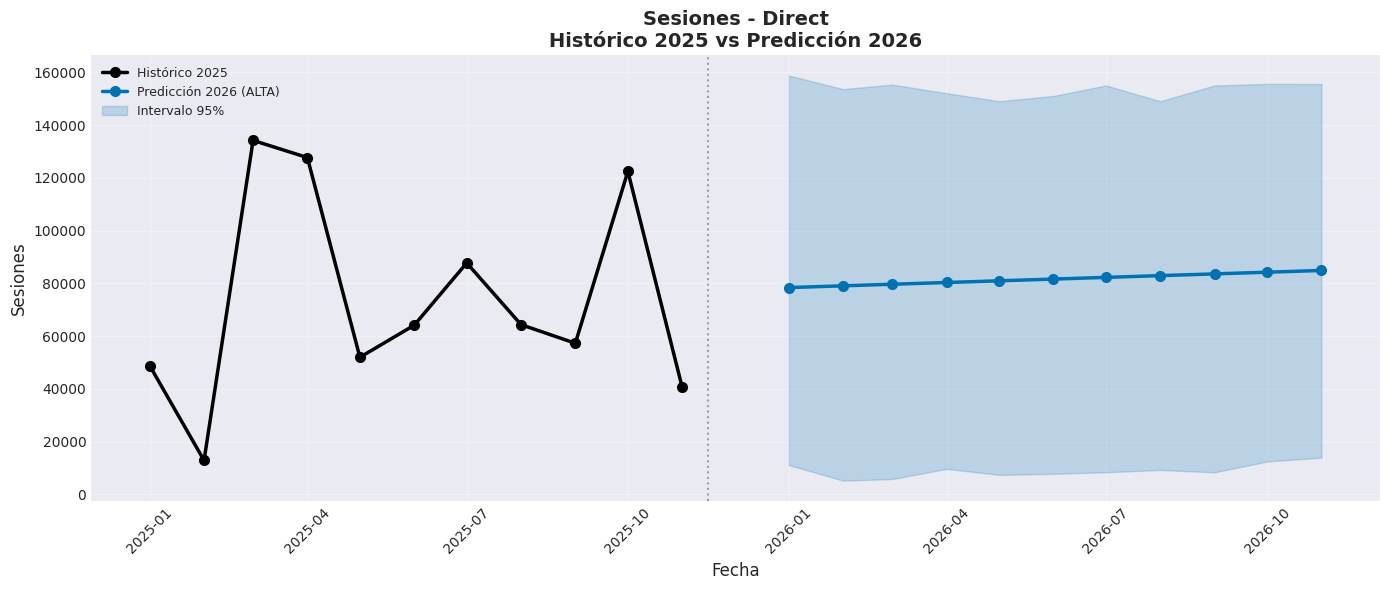

   Gráfico: Bounce Rate (%)


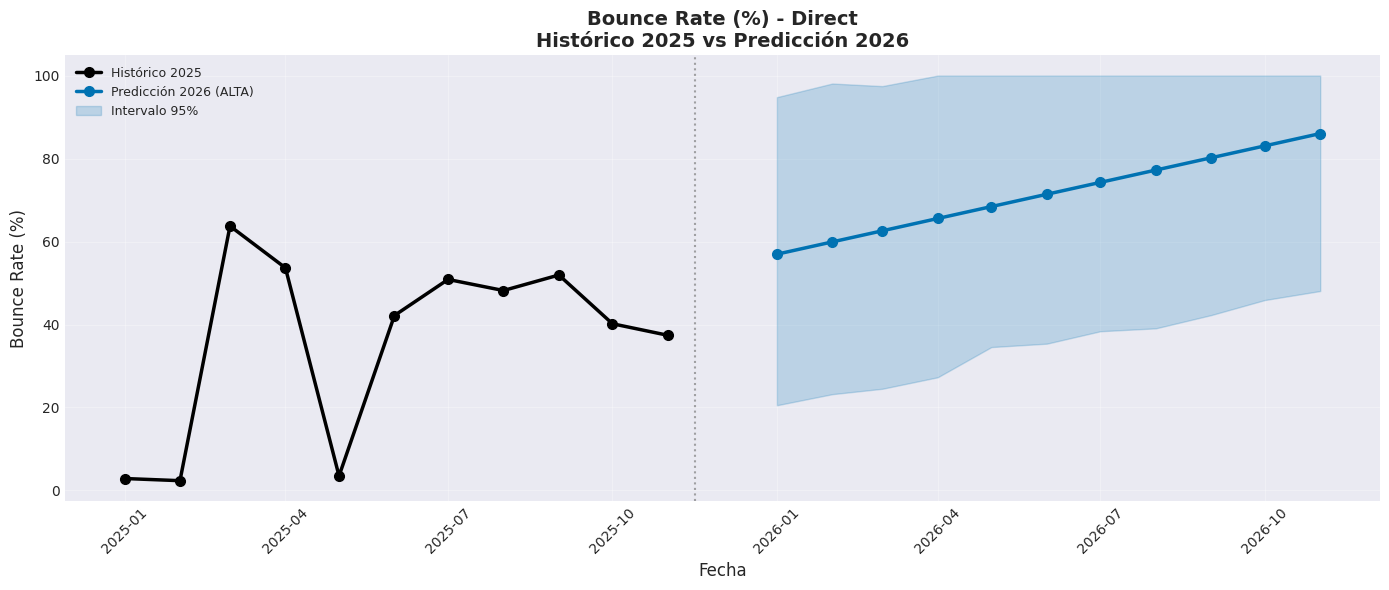

   Gráfico: Vistas por Sesión


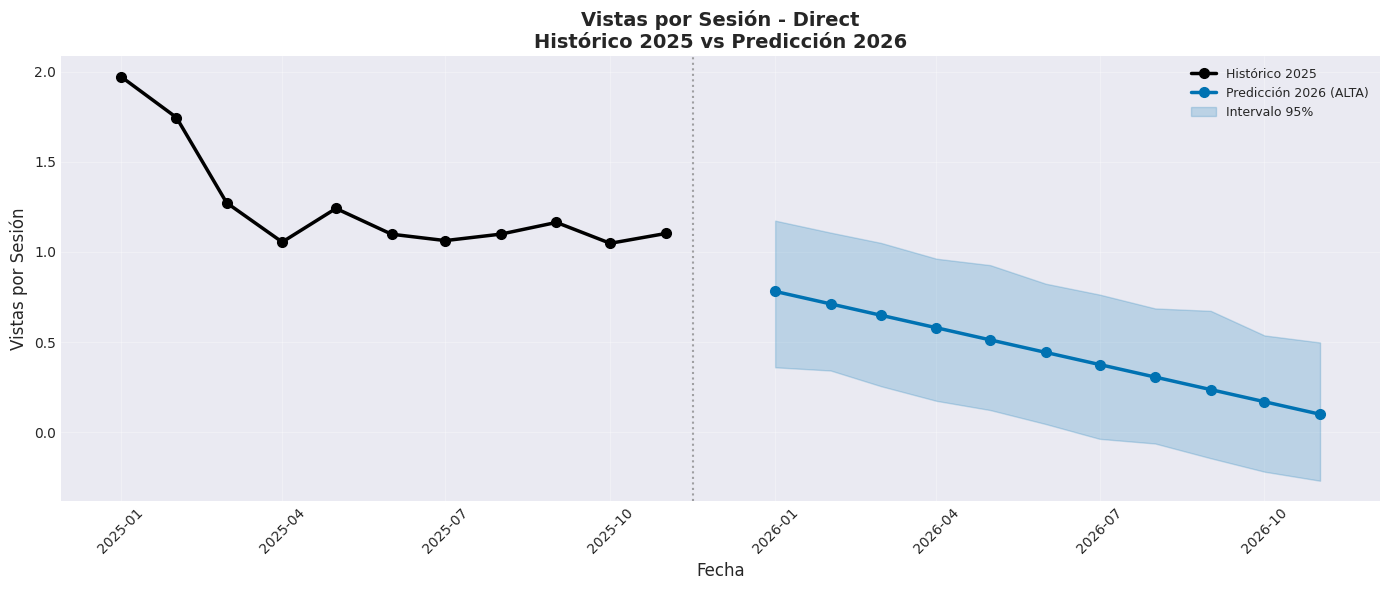

   Gráfico: Duración Promedio (segundos)


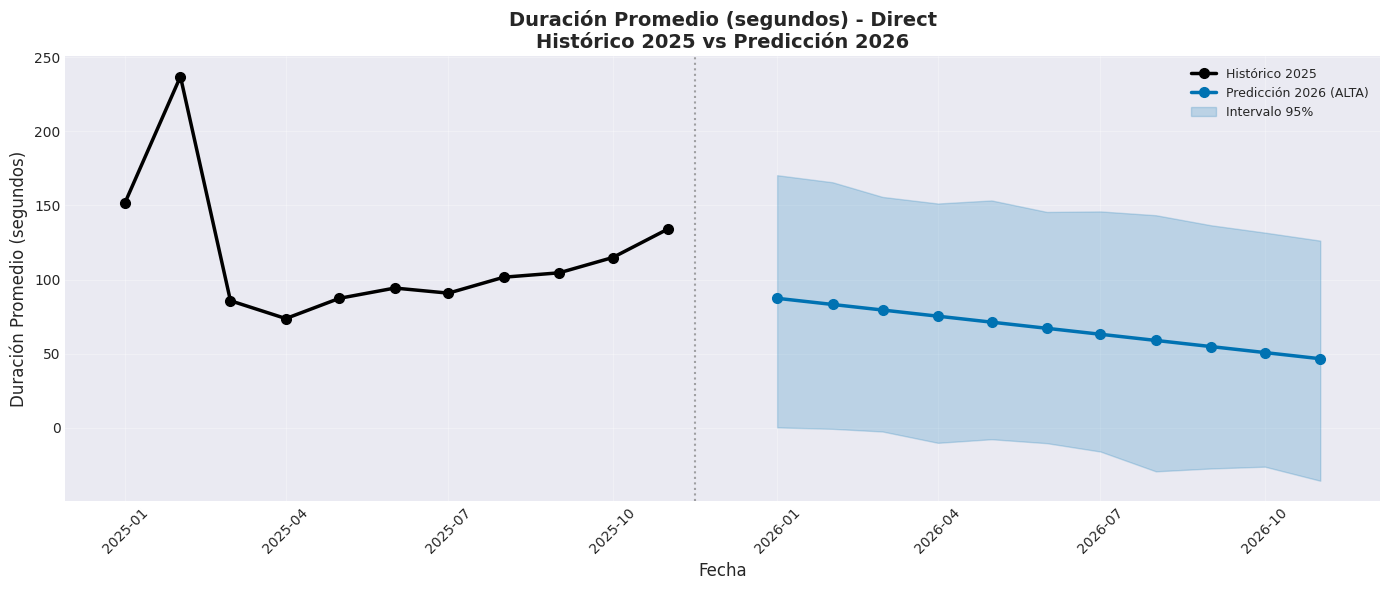


📈 Canal: Organic Search
----------------------------------------------------------------------
   Gráfico: Sesiones


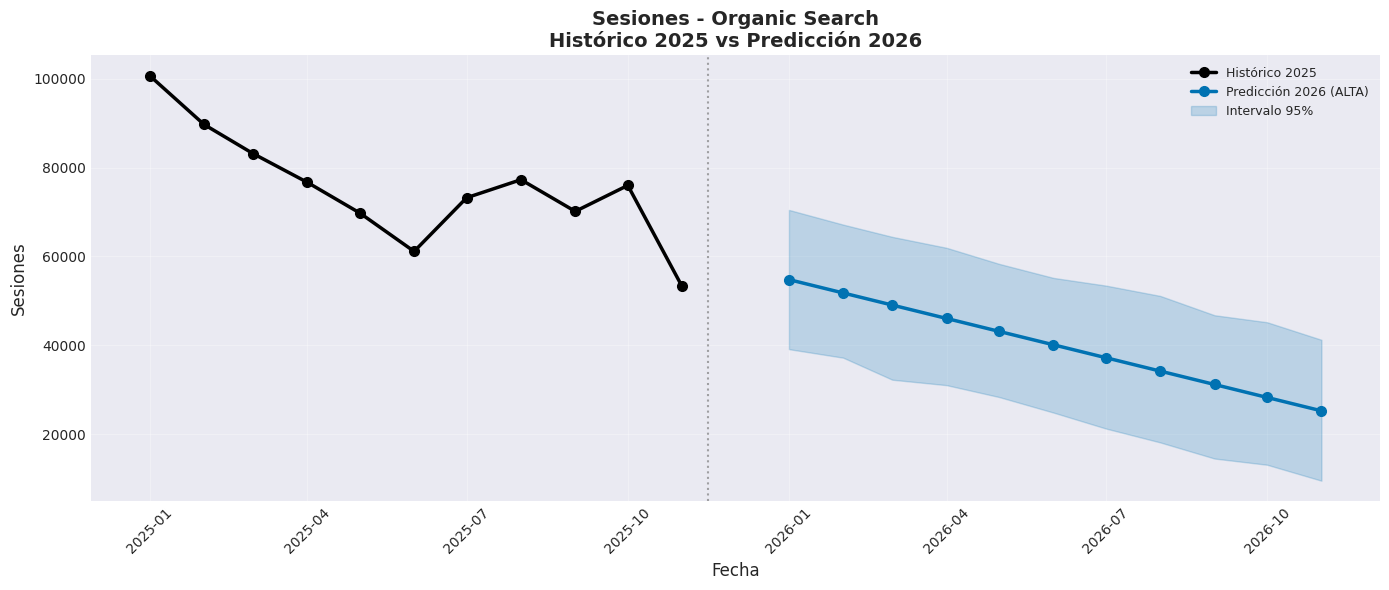

   Gráfico: Bounce Rate (%)


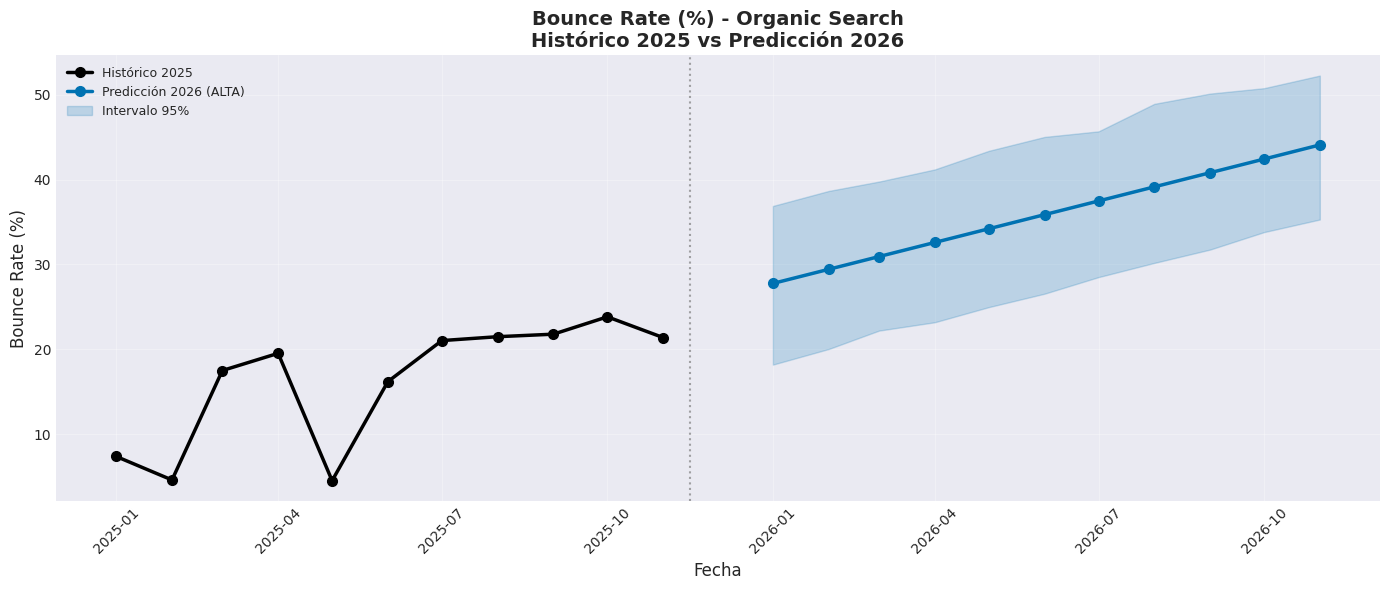

   Gráfico: Vistas por Sesión


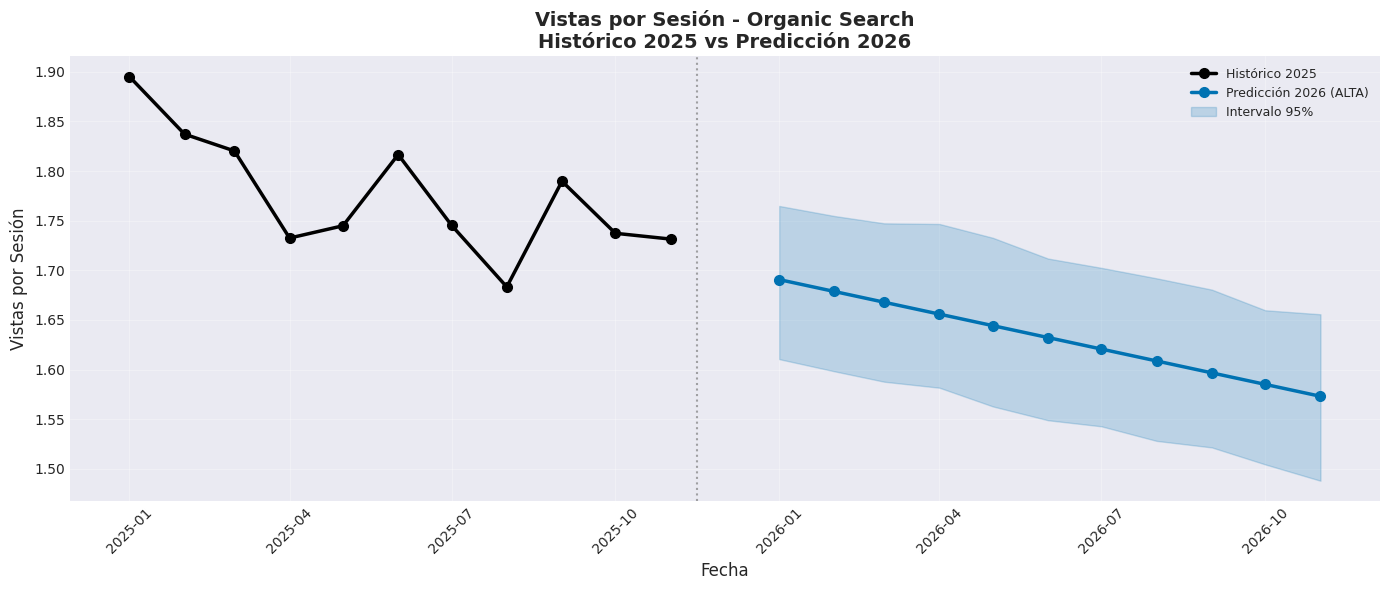

   Gráfico: Duración Promedio (segundos)


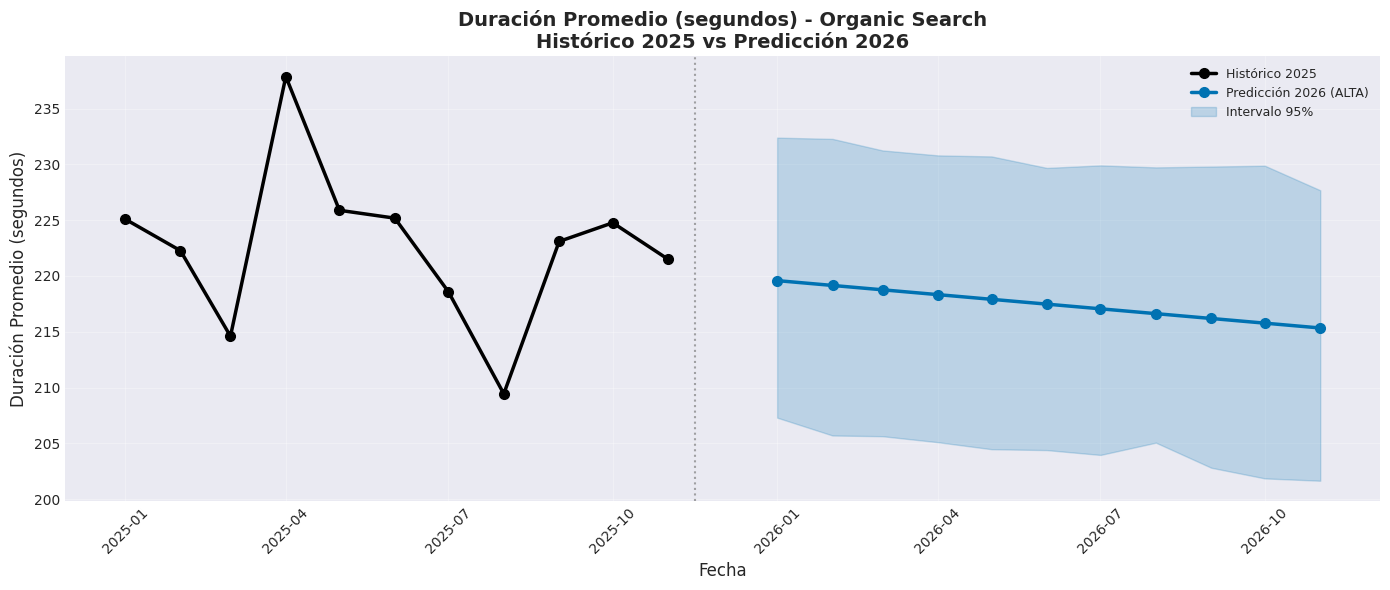


📈 Canal: Organic Social
----------------------------------------------------------------------
   Gráfico: Sesiones


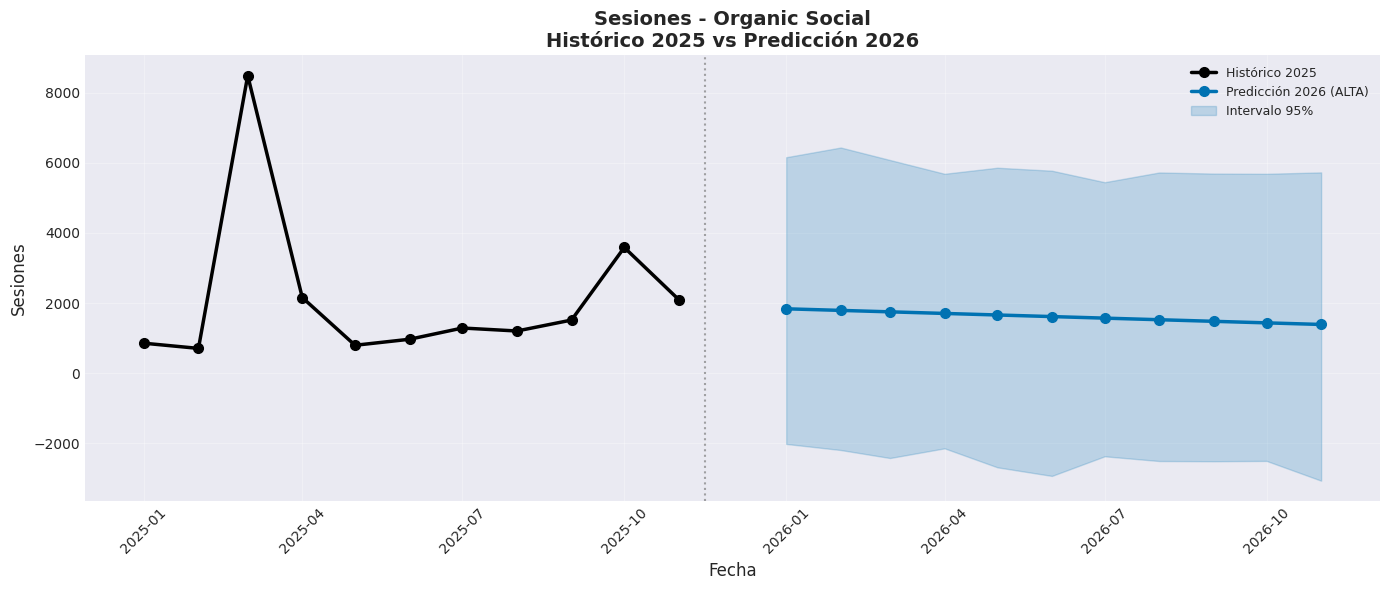

   Gráfico: Bounce Rate (%)


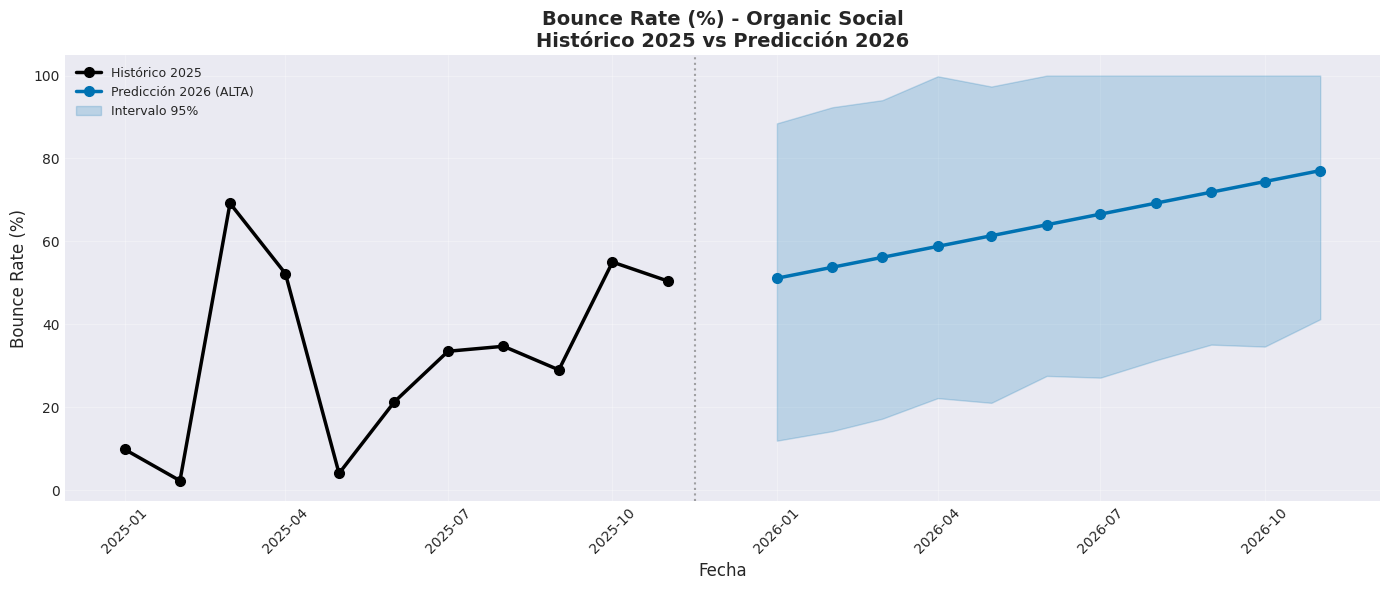

   Gráfico: Vistas por Sesión


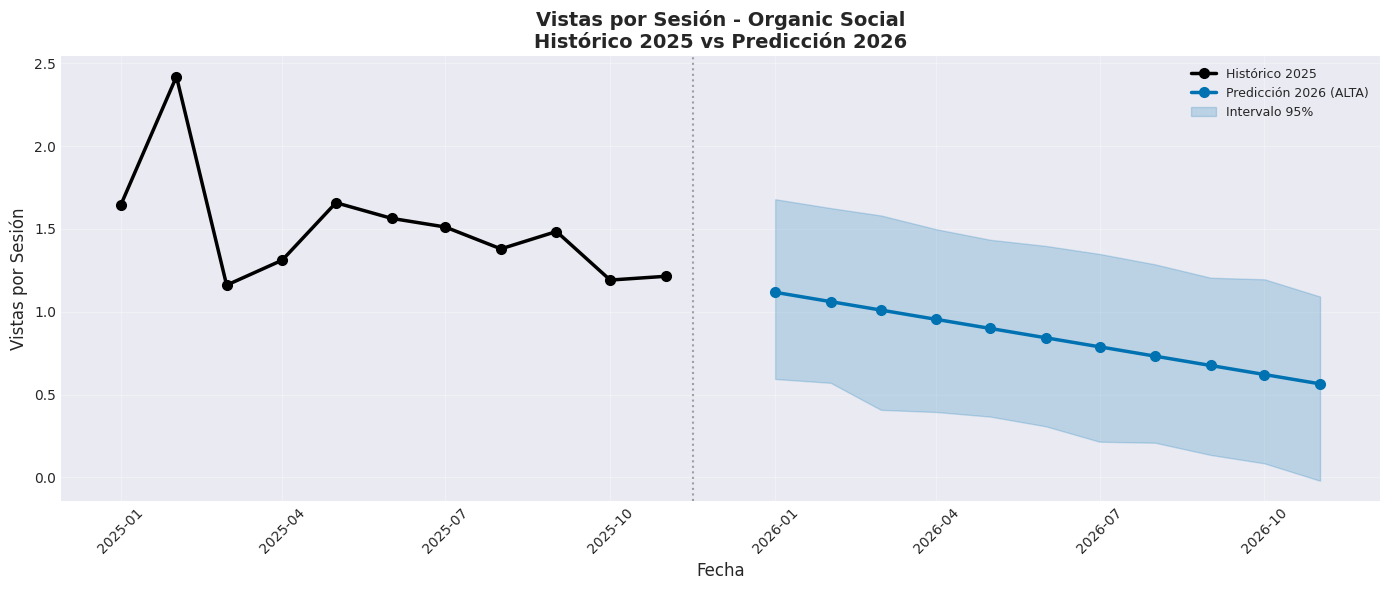

   Gráfico: Duración Promedio (segundos)


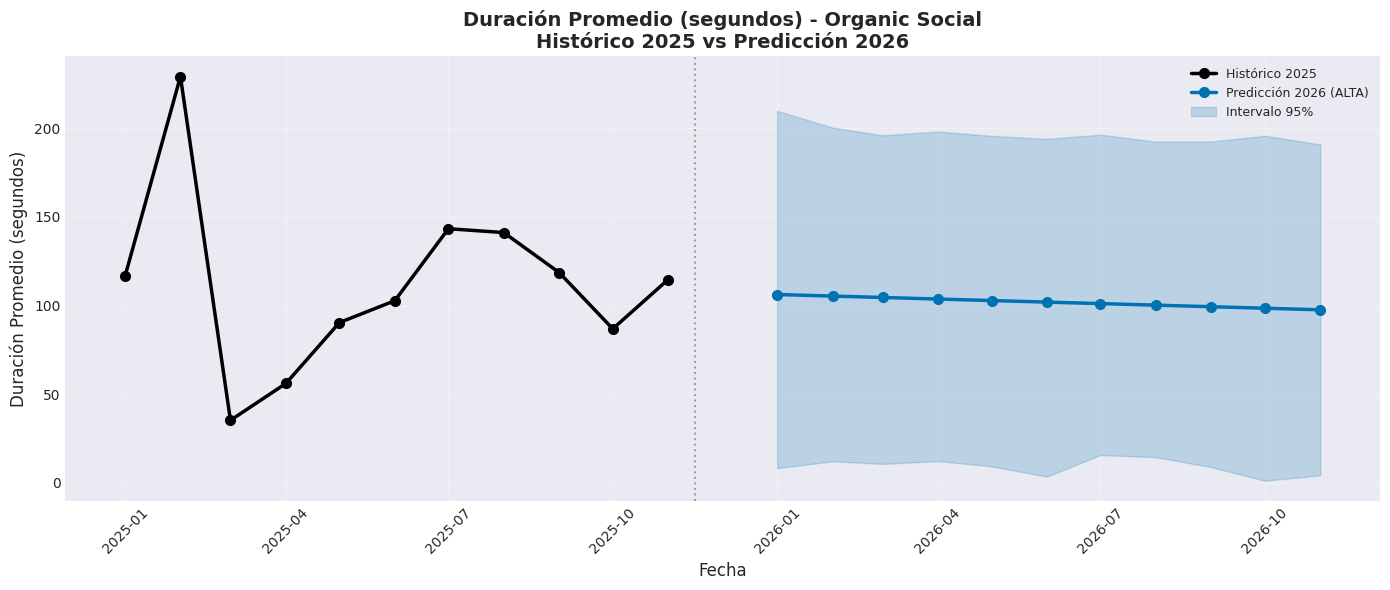


✅ 16 gráficos generados y guardados
📁 Ubicación: ../results/figures/final


In [128]:
# Generar gráficos para TODAS las métricas de TODOS los canales
print("📊 Generando gráficos comparativos para todas las métricas...\n")

metricas_titulos = {
    'sessions': 'Sesiones',
    'bounce_rate': 'Bounce Rate (%)',
    'views_per_session': 'Vistas por Sesión',
    'avg_session_duration': 'Duración Promedio (segundos)'
}

graficos_generados = 0

for canal in canales:
    print(f"\n📈 Canal: {canal}")
    print("-" * 70)
    
    for metrica, titulo in metricas_titulos.items():
        print(f"   Gráfico: {titulo}")
        
        fig, ax = plt.subplots(figsize=(14, 6))
        
        # Histórico
        df_hist = df_output[df_output['channel'] == canal].sort_values('ds')
        ax.plot(df_hist['ds'], df_hist[metrica], 
                'o-', color='black', label='Histórico 2025', linewidth=2.5, markersize=7)
        
        # Predicción
        df_pred = df_predicciones[(df_predicciones['channel'] == canal) & 
                                  (df_predicciones['metric'] == metrica)].sort_values('ds')
        
        conf = df_confiabilidad[df_confiabilidad['canal'] == canal]['confiabilidad'].values[0]
        color = '#0072B2' if conf in ['ALTA', 'MEDIA'] else '#D55E00'
        linestyle = '-' if conf in ['ALTA', 'MEDIA'] else '--'
        
        ax.plot(df_pred['ds'], df_pred['predicted_value'], 
                'o-', color=color, label=f'Predicción 2026 ({conf})', 
                linewidth=2.5, markersize=7, linestyle=linestyle)
        
        ax.fill_between(df_pred['ds'], df_pred['lower_bound'], df_pred['upper_bound'],
                        alpha=0.2, color=color, label='Intervalo 95%')
        
        # Línea separadora
        fecha_sep = df_hist['ds'].max() + pd.DateOffset(days=15)
        ax.axvline(x=fecha_sep, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
        
        # Advertencia si baja confiabilidad
        if conf == 'BAJA':
            problemas = df_confiabilidad[df_confiabilidad['canal'] == canal]['problemas'].values[0]
            ax.text(0.5, 0.95, f'⚠️ ADVERTENCIA: {problemas}', 
                    transform=ax.transAxes, fontsize=10, color='red',
                    ha='center', va='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
        
        ax.set_title(f'{titulo} - {canal}\nHistórico 2025 vs Predicción 2026', 
                     fontsize=14, fontweight='bold')
        ax.set_xlabel('Fecha', fontsize=12)
        ax.set_ylabel(titulo, fontsize=12)
        ax.legend(loc='best', fontsize=9)
        ax.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        filename = f"comp_{metrica}_{canal.replace(' ', '_').lower()}.png"
        plt.savefig(RESULTS_FIGURES_FINAL / filename, dpi=300, bbox_inches='tight')
        plt.show()
        
        graficos_generados += 1

print(f"\n" + "="*70)
print(f"✅ {graficos_generados} gráficos generados y guardados")
print(f"📁 Ubicación: {RESULTS_FIGURES_FINAL}")

## 4.5 Resumen ejecutivo

In [129]:
# Resumen ejecutivo final
print("="*80)
print("🎯 RESUMEN EJECUTIVO - PREDICCIONES 2026")
print("="*80)

print("\n📊 PREDICCIONES POR CANAL:\n")

for canal in sorted(canales):
    conf = df_confiabilidad[df_confiabilidad['canal'] == canal]['confiabilidad'].values[0]
    icono = '✅' if conf == 'ALTA' else ('⚠️' if conf == 'MEDIA' else '🚨')
    
    print(f"\n{icono} {canal} (Confiabilidad: {conf})")
    
    df_canal = df_predicciones[df_predicciones['channel'] == canal]
    
    sessions = df_canal[df_canal['metric'] == 'sessions']['predicted_value'].sum()
    bounce = df_canal[df_canal['metric'] == 'bounce_rate']['predicted_value'].mean()
    vps = df_canal[df_canal['metric'] == 'views_per_session']['predicted_value'].mean()
    dur = df_canal[df_canal['metric'] == 'avg_session_duration']['predicted_value'].mean()
    
    print(f"   Sesiones totales 2026: {sessions:,.0f}")
    print(f"   Bounce Rate promedio: {bounce:.1f}%")
    print(f"   Vistas/Sesión: {vps:.2f}")
    print(f"   Duración promedio: {segundos_a_hhmm_ss(dur)} ({dur:.0f} seg)")

print("\n" + "="*80)
print("\n✅ ANÁLISIS COMPLETADO")
print("="*80)

🎯 RESUMEN EJECUTIVO - PREDICCIONES 2026

📊 PREDICCIONES POR CANAL:


⚠️ AI Traffic (Confiabilidad: MEDIA)
   Sesiones totales 2026: 11,799
   Bounce Rate promedio: 38.9%
   Vistas/Sesión: 1.71
   Duración promedio: 00:04:45 (286 seg)

✅ Direct (Confiabilidad: ALTA)
   Sesiones totales 2026: 897,985
   Bounce Rate promedio: 71.4%
   Vistas/Sesión: 0.44
   Duración promedio: 00:01:07 (67 seg)

✅ Organic Search (Confiabilidad: ALTA)
   Sesiones totales 2026: 441,102
   Bounce Rate promedio: 35.9%
   Vistas/Sesión: 1.63
   Duración promedio: 00:03:37 (217 seg)

✅ Organic Social (Confiabilidad: ALTA)
   Sesiones totales 2026: 17,738
   Bounce Rate promedio: 64.0%
   Vistas/Sesión: 0.84
   Duración promedio: 00:01:41 (102 seg)


✅ ANÁLISIS COMPLETADO


---
# SECCIÓN 5: DESCARGA DE RESULTADOS (Solo Colab)
---

In [130]:
if IN_COLAB:
    from google.colab import files
    import zipfile
    import os
    
    print("📦 Preparando archivos para descarga...\n")
    
    # Crear ZIP con todos los resultados
    zip_filename = 'resultados_forecast_promtur.zip'
    
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        # Agregar CSVs
        for file in ['data/processed/dataset_clean.csv', 
                     'data/forecasts/forecasts_2026_all_channels.csv',
                     'results/reports/canales_confiabilidad.csv']:
            if os.path.exists(file):
                zipf.write(file)
        
        # Agregar Excel
        if os.path.exists('results/reports/tablas_resumen_2026.xlsx'):
            zipf.write('results/reports/tablas_resumen_2026.xlsx')
        
        # Agregar gráficos
        for root, dirs, files_list in os.walk('results/figures'):
            for file in files_list:
                if file.endswith('.png'):
                    filepath = os.path.join(root, file)
                    zipf.write(filepath)
    
    print(f"✅ Archivo ZIP creado: {zip_filename}")
    print(f"📊 Total de gráficos incluidos: {graficos_generados}")
    print("\n📥 Descargando resultados...\n")
    
    files.download(zip_filename)
    
    print("\n" + "="*80)
    print("✅ DESCARGA COMPLETADA")
    print("="*80)
    print("\nEl archivo ZIP contiene:")
    print("  - Dataset limpio (CSV)")
    print("  - Predicciones 2026 (CSV)")
    print("  - Tablas resumen por canal (Excel con HH:MM:SS)")
    print("  - Análisis de confiabilidad (CSV)")
    print(f"  - {graficos_generados} gráficos comparativos (PNG)")
else:
    print("🟢 Entorno local: Todos los archivos están guardados en sus carpetas correspondientes")
    print(f"\n📊 Total de gráficos generados: {graficos_generados}")

🟢 Entorno local: Todos los archivos están guardados en sus carpetas correspondientes

📊 Total de gráficos generados: 16


---

## ¡ANÁLISIS COMPLETADO!

### Archivos generados:

**Datos:**
- `data/processed/dataset_clean.csv` - Dataset limpio
- `data/forecasts/forecasts_2026_all_channels.csv` - Predicciones 2026

**Reportes:**
- `results/reports/tablas_resumen_2026.xlsx` - Tablas por canal con duración en HH:MM:SS
- `results/reports/canales_confiabilidad.csv` - Análisis de confiabilidad

**Visualizaciones:**
- `results/figures/exploratory/` - Gráficos exploratorios
- `results/figures/final/` - Gráficos comparativos de TODAS las métricas

---

### ⚠️ Consideraciones importantes:

1. **Bounce Rate**: Limitado automáticamente a rango 0-100%
2. **Canales con baja confiabilidad**: Señalizados en gráficos y análisis
3. **Intervalos de confianza**: Reflejan incertidumbre del modelo
4. **Duración de sesión**: Disponible en segundos y formato HH:MM:SS

### Recomendaciones:

- Usar predicciones de canales con confiabilidad ALTA/MEDIA
- Considerar intervalos de confianza en planificación
- Actualizar modelos con datos reales de 2026
- Incorporar datos de 2024 cuando estén disponibles

---

**Fecha:** Noviembre 2025